In [ ]:
"""
Prepare some masks for ORCA1
"""

In [1]:
import xarray as xr

In [2]:
inputpath = '/data/cburgard/PREPARE_FORCING/'

In [3]:
data_bathy = xr.open_dataset(inputpath + 'eORCA_R1_bathy_meter_v2.2.nc')

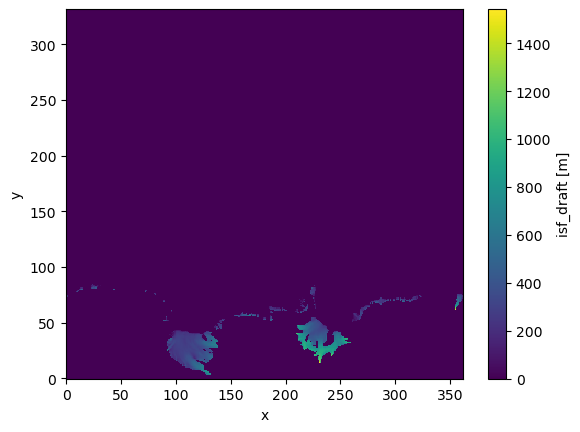